## Setup

Common imports (not all needed)

In [1]:
import os
import pathlib
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm.notebook

# Custom utils for rasterio
from src.data_loading.rasterio_utils import get_thumbnail, read_from_lat_lon
from src.data_loading.vector_utils import shapely_to_frame
#from src.data_loading.landcover_plot_utils import classes_to_rgb
from src.utils import get_byte_size, get_osm_polygon

# Path to ESA Landcover datasets on Jasmin
from src.constants import ESA_LANDCOVER_DIR, GWS_DATA_DIR, WGS84, PREFERRED_CRS

# For loading geotiff data
import rioxarray as rxr
import rasterio
from rasterio.mask import mask
from rasterio.crs import CRS
import pylandstats as pls

# For loading and manipulating vector data
import geopandas as gpd
from shapely.geometry import box, Point

# For conveniently getting longitude, latitude from name (& geodesic distances)
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="fragmentation-analysis")
logger = logging.getLogger()
logger.setLevel(logging.INFO)

import osgeo.gdal
import numpy.ma as ma

## Landsat Data

Inspecting landsat data

In [2]:
landsat_path = GWS_DATA_DIR / 'gee_satellite_data'

In [3]:
landsat_chern_2015_JAS = rasterio.open(landsat_path/ '2015/L8_chern_2015_JAS.tif')

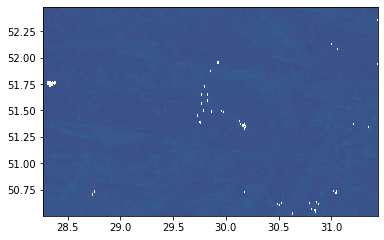

<AxesSubplot:>

In [4]:
#Inspect data:

from rasterio.plot import show
show(landsat_chern_2015_JAS)  

In [5]:
#Load as an array
with rasterio.open(landsat_path/ '2015/L8_chern_2015_JAS.tif') as ds:
    arr_L8_chern_2015_JAS = ds.read()
    
print(arr_L8_chern_2015_JAS.shape)    #[band, row, column]

(4, 7361, 11776)


## ESA CCI landcover data

In [9]:
input_filepaths = [GWS_DATA_DIR / "esa_cci_rois" / f"esa_cci_{year}_chernobyl.geojson" for year in range(1992, 2016)]

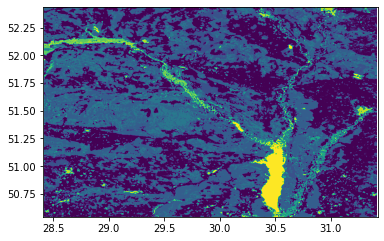

<AxesSubplot:>

In [10]:
chernobyl_2015_wgs84 = rasterio.open(input_filepaths[-1])
show(chernobyl_2015_wgs84)

In [11]:
chernobyl_2015_wgs84.shape

(681, 1086)

## Habitat data

In [12]:
landsat_hab_2019_JAS = rasterio.open(landsat_path/ '2019/L8_hab_2019_JAS.tif')

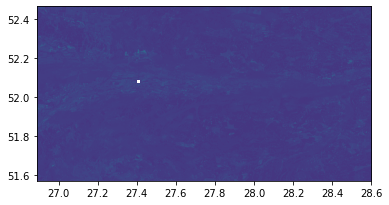

<AxesSubplot:>

In [13]:
from rasterio.plot import show
show(landsat_hab_2019_JAS)

In [14]:
#Load as an array
with rasterio.open(landsat_path/ '2019/L8_hab_2019_JAS.tif') as ds:
    arr_L8_hab_2019_JAS = ds.read()
    
print(arr_L8_hab_2019_JAS.shape)    #[band, row, column]

(4, 3313, 6360)


## Try to rasterize Polesia Habitat data

In [16]:
# Getting biotope data
bio_path = GWS_DATA_DIR / "chernobyl_habitat_data" / "Biotope_EUNIS_ver1.shp"
bio_data = gpd.read_file(bio_path)

<AxesSubplot:>

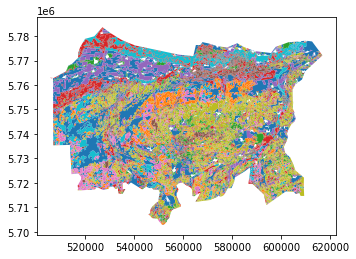

In [17]:
biotope_data = gpd.read_file(GWS_DATA_DIR / "chernobyl_habitat_data" / "Biotope_EUNIS_ver1_1.shp")
# print(biotope_data.crs.__repr__())
biotope_data.plot("Eunis_name")
# biotope_data.sample(10)

In [18]:
biotope_data.head()

,OBJECTID,N_Eunis,Eunis_name,Shape_Leng,Shape_Area,Leg,AREA,geometry
0,44,C,Inland surface waters,1738.710883,77048.834598,1,7.70488,"POLYGON Z ((567349.222 5719076.917 0.000, 5673..."
1,45,C,Inland surface waters,33664.380335,329068.268246,1,32.90680,"POLYGON Z ((567359.453 5724545.845 0.000, 5673..."
2,46,C,Inland surface waters,1959.774812,92434.934227,1,9.24349,"POLYGON Z ((583966.896 5730868.298 0.000, 5840..."
3,47,C,Inland surface waters,3556.603641,851449.759888,1,85.14500,"POLYGON Z ((507999.789 5737888.108 0.000, 5079..."
4,48,C,Inland surface waters,4086.548341,888119.110061,1,88.81190,"POLYGON Z ((588941.960 5755636.366 0.000, 5896..."


In [85]:
biotope_data.crs
#print(len(biotope_data))

<Projected CRS: EPSG:32635>
Name: WGS 84 / UTM zone 35N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - N hemisphere - 24°E to 30°E - by country
- bounds: (24.0, 0.0, 30.0, 84.0)
Coordinate Operation:
- name: UTM zone 35N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [86]:
from osgeo import gdal, ogr

# Define pixel_size and NoData value of new raster
pixel_size = 30
NoData_value = 0

# Filename of input OGR file
vector_fn = "/gws/nopw/j04/ai4er/guided-team-challenge/2021/biodiversity/chernobyl_habitat_data/Biotope_EUNIS_ver1.shp"

# Filename of the raster Tiff that will be created
raster_fn = 'test.tif'

# Open the data source and read in the extent
source_ds = ogr.Open(vector_fn)
source_layer = source_ds.GetLayer() 
x_min, x_max, y_min, y_max = source_layer.GetExtent()  #edges of bounding box

layer = source_ds.GetLayerByIndex(0)
print('The layer is named: {n}\n'.format(n=layer.GetName()))
### What is the layer's geometry? is it a point? a polyline? a polygon?
geometry = layer.GetGeomType()
geometry_name = ogr.GeometryTypeToName(geometry)
print("The layer's geometry is: {geom}\n".format(geom=geometry_name))

### What is the layer's projection?
# Get the spatial reference
spatial_ref = layer.GetSpatialRef()

# Export this spatial reference to something we can read... like the Proj4
proj4 = spatial_ref.ExportToProj4()
print('Layer projection is: {proj4}\n'.format(proj4=proj4))

### How many features are in the layer? (polygons)
feature_count = layer.GetFeatureCount()
print('Layer has {n} features\n'.format(n=feature_count))

### How many fields are in the shapefile, and what are their names?
# First we need to capture the layer definition
defn = layer.GetLayerDefn()

# How many fields
field_count = defn.GetFieldCount()
print('Layer has {n} fields'.format(n=field_count))

# What are their names?
print('Their names are: ')
for i in range(field_count):
    field_defn = defn.GetFieldDefn(i)
    print('\t{name} - {datatype}'.format(name=field_defn.GetName(),
                                         datatype=field_defn.GetTypeName()))
    
#want OBJECTID and Eunis_name

The layer is named: Biotope_EUNIS_ver1

The layer's geometry is: 3D Polygon

Layer projection is: +proj=utm +zone=35 +datum=WGS84 +units=m +no_defs

Layer has 13616 features

Layer has 7 fields
Their names are: 
	OBJECTID - Integer64
	N_Eunis - String
	Eunis_name - String
	Shape_Leng - Real
	Shape_Area - Real
	Leg - Integer64
	AREA - Real


success


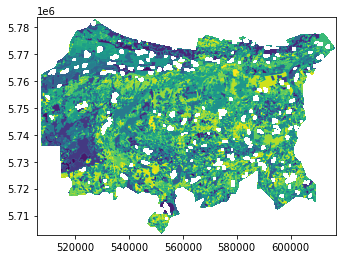

<AxesSubplot:>

In [87]:
# Create the destination data source
x_res = int((x_max - x_min) / pixel_size)
y_res = int((y_max - y_min) / pixel_size)
target_ds = gdal.GetDriverByName('GTiff').Create(raster_fn, x_res, y_res, 1, gdal.GDT_Byte)
target_ds.SetGeoTransform((x_min, pixel_size, 0, y_max, 0, -pixel_size))
band = target_ds.GetRasterBand(1)
band.SetNoDataValue(0)
#band.fill(0)

# Rasterize
status = gdal.RasterizeLayer(target_ds, #output to new dataset
                    [1], #output to new dataset's first band
                    source_layer,  #rasterize this layer
                    None, None,
                    [0], #burn value 0
                    ['ALL_TOUCHED=TRUE',  #rasterize all pixels touched by polygons
                    'ATTRIBUTE=OBJECTID'])
#Close dataset
target_ds = None

if status != 0:
    print('Not worked')
else:
    print('success')

raster = gdal.Open('test.tif')


test = rasterio.open('test.tif')
show(test)


In [83]:
#Load as an array
with rasterio.open('test.tif') as ds:
    test = ds.read()
    
print(test.shape)    #[band, row, column]

(1, 16156, 22250)


In [84]:
roi_ds = gdal.Open('test.tif', gdal.GA_ReadOnly)     #Why is this coming up with 255 classes?

roi = roi_ds.GetRasterBand(1).ReadAsArray()

# How many pixels are in each class?
classes = np.unique(roi)
for c in classes:
    print('Class {c} contains {n} pixels'.format(c=c,
                                                 n=(roi == c).sum()))

Class 0 contains 133640485 pixels
Class 1 contains 495612 pixels
Class 2 contains 678112 pixels
Class 3 contains 642562 pixels
Class 4 contains 389567 pixels
Class 5 contains 1064336 pixels
Class 6 contains 561189 pixels
Class 7 contains 601679 pixels
Class 8 contains 991443 pixels
Class 9 contains 747270 pixels
Class 10 contains 478574 pixels
Class 11 contains 635446 pixels
Class 12 contains 511578 pixels
Class 13 contains 358411 pixels
Class 14 contains 649208 pixels
Class 15 contains 1024854 pixels
Class 16 contains 616576 pixels
Class 17 contains 774845 pixels
Class 18 contains 2334105 pixels
Class 19 contains 474607 pixels
Class 20 contains 496603 pixels
Class 21 contains 455051 pixels
Class 22 contains 1162266 pixels
Class 23 contains 660468 pixels
Class 24 contains 601094 pixels
Class 25 contains 402908 pixels
Class 26 contains 943373 pixels
Class 27 contains 1263388 pixels
Class 28 contains 1494597 pixels
Class 29 contains 659919 pixels
Class 30 contains 7173901 pixels
Class 31

Class 250 contains 606426 pixels
Class 251 contains 464214 pixels
Class 252 contains 503253 pixels
Class 253 contains 1015085 pixels
Class 254 contains 333414 pixels
Class 255 contains 7502029 pixels


In [79]:
#ls = pls.Landscape('test.tif')

In [80]:
#ls.plot_landscape(legend=True)